In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mlrose_hiive as mlrose

from mlrose_hiive import ContinuousPeaksGenerator, TSPGenerator, FlipFlopGenerator
from mlrose_hiive import random_hill_climb, SARunner, ExpDecay, GARunner, MIMICRunner

np.random.seed(21)

# Part 1: Discrete Optimization Problems

### Function to Run Algorithms

In [2]:
def run_random_op(problem, p_name):
    
    # random hill climb
    rhc = pd.DataFrame(random_hill_climb(problem, curve=True, restarts=10, max_iters=5000)[2])
    print('rhc done')
    
    # sim annealing
    sa = {}
    for c in [0.15, 0.35, 0.55, 0.75, 0.95]:
        sa_state, sa_fitness, sa_curve = mlrose.simulated_annealing(problem, 
                                        schedule=ExpDecay(exp_const=c, init_temp=10**10), 
                                        max_attempts=100, max_iters=5000, curve=True,
                                        random_state=21)
        sa[c] = sa_curve
        
        print('sa done: ', c)
    
    # genetic algo
    ga = GARunner(problem=problem,
              seed=21,
              experiment_name='ga',
              iteration_list=[5000],
              population_sizes=[100],
              mutation_rates=[0.5, 0.3, 0.1])
    ga_run_stats, ga_run_curves = ga.run()
    curves_ga = ga_run_curves.pivot(index='Iteration', columns='Mutation Rate', values='Fitness').fillna(method='ffill')
    
    print('ga done')
    
    # mimic
    mm = MIMICRunner(problem=problem, 
                 seed=21,
                 experiment_name='mimic', 
                 iteration_list=[5000],
                 population_sizes=[100],
                 keep_percent_list=[0.1, 0.3, 0.5, 0.7, 0.9])

    mm_run_stats, mm_run_curves = mm.run()
    curves_mm = mm_run_curves.pivot(index='Iteration', columns='Keep Percent', values='Fitness')
    print('mimic done')
    
    ### PLOTTING ###
    fig, axes = plt.subplots(2, 2, figsize=(20, 13))

    # Random Hill Climb
    axes[0][0].plot(rhc[0], label='Fitness (Distance)')
    axes[0][0].set_xlabel('No. of Iterations')
    axes[0][0].set_ylabel('Fitness')
    axes[0][0].set_title('Random Hill Climb', fontsize='x-large')
    axes[0][0].legend(title_fontsize='medium')

    # Simulated Annealing
    for c in [0.15, 0.35, 0.55, 0.75, 0.95]:
        test = pd.DataFrame(sa[c])
        axes[0][1].plot(test[1], test[0], label=f'Cooling Exponent={c}')
    axes[0][1].set_xlabel('No. of Iterations')
    axes[0][1].set_ylabel('Fitness')
    axes[0][1].set_title('Simulated Annealing', fontsize='x-large')
    axes[0][1].legend(title_fontsize='medium')

    # Genetic
    axes[1][0].plot(curves_ga[0.1], label='Mutation=10')
    axes[1][0].plot(curves_ga[0.3], label='Mutation=30')
    axes[1][0].plot(curves_ga[0.5], label='Mutation=50')
    axes[1][0].set_title('Genetic Algorithm', fontsize='x-large')
    axes[1][0].set_xlabel('No. of Iterations')
    axes[1][0].set_ylabel('Fitness')
    axes[1][0].legend(title_fontsize='medium')
    
    # MIMIC
    for k in [0.1, 0.3, 0.5, 0.7, 0.9]:
        axes[1][1].plot(curves_mm[k], label=f'M={k}')
    axes[1][1].set_xlabel('No. of Iterations')
    axes[1][1].set_ylabel('Fitness')
    axes[1][1].set_title('MIMIC', fontsize='x-large')
    axes[1][1].legend(title_fontsize='medium')

    fig.suptitle(f'{p_name}: Fitness Curves', fontsize='xx-large', y=0.93);
    
    return rhc, sa, ga_run_curves, mm_run_curves
    
    

## Traveling Salesman Problem

rhc done
sa done:  0.15
sa done:  0.35
sa done:  0.55
sa done:  0.75
sa done:  0.95
ga done
mimic done


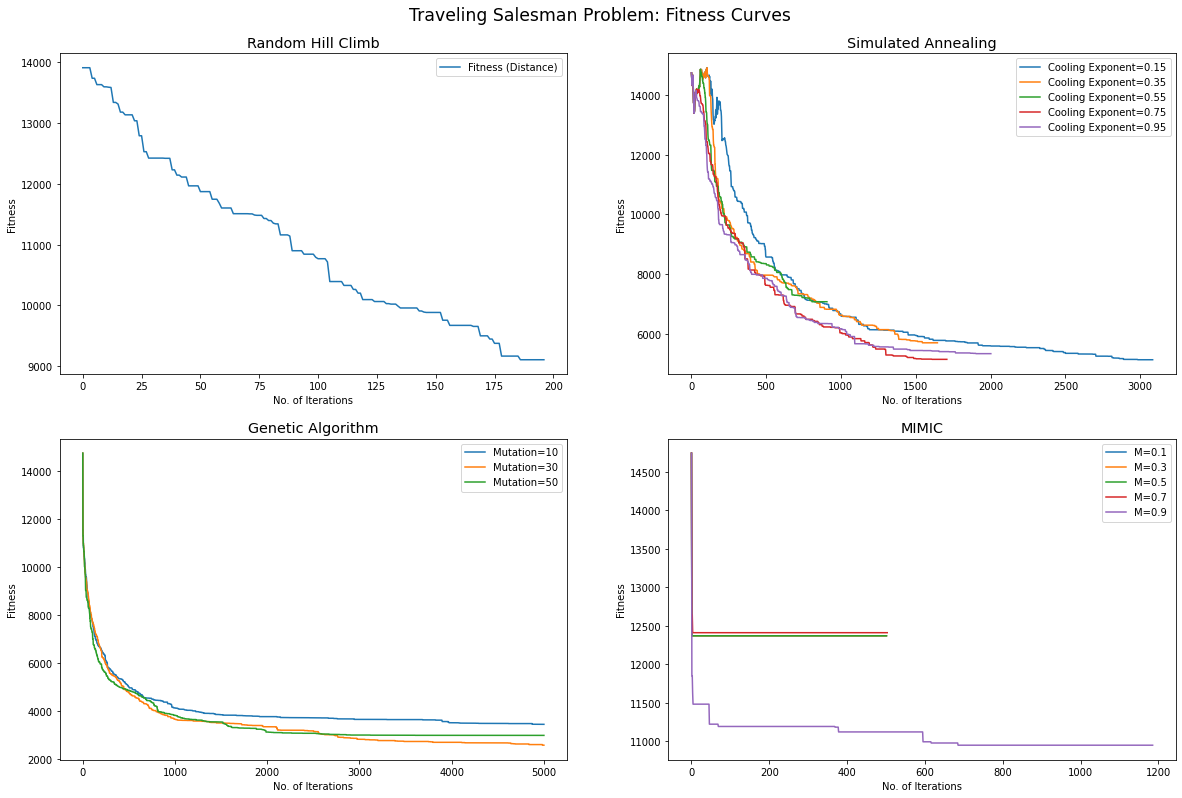

In [3]:
tsp = TSPGenerator().generate(seed=21, number_of_cities=100)
tsp_out = run_random_op(tsp, 'Traveling Salesman Problem')

In [4]:
tsp_rhc, tsp_sa, tsp_ga, tsp_m = tsp_out

In [7]:
tsp_rhc[tsp_rhc[0]==tsp_rhc[0].min()]

,0,1
186,9105.638189,1689.0
187,9105.638189,1690.0
188,9105.638189,1691.0
189,9105.638189,1692.0
190,9105.638189,1693.0
191,9105.638189,1694.0
192,9105.638189,1695.0
193,9105.638189,1696.0
194,9105.638189,1697.0
195,9105.638189,1698.0


In [22]:
sa15 = pd.DataFrame(tsp_sa[0.15])
sa15[sa15[0]==sa15[0].min()]

,0,1
2699,5130.208622,2983.0
2700,5130.208622,2984.0
2701,5130.208622,2985.0
2702,5130.208622,2986.0
2703,5130.208622,2987.0
...,...,...
2795,5130.208622,3079.0
2796,5130.208622,3080.0
2797,5130.208622,3081.0
2798,5130.208622,3082.0


In [8]:
# ga
tsp_ga.groupby('Mutation Rate').min()

,Iteration,Time,Fitness,FEvals,Population Size,max_iters
Mutation Rate,,,,,,
0.1,0,0.0169,3457.047691,100.0,100,5000
0.3,0,0.0169,2588.495668,100.0,100,5000
0.5,0,0.0169,2997.147447,100.0,100,5000


In [10]:
tsp_ga[tsp_ga.Fitness==tsp_ga.Fitness.min()]

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
9278,4984,32.144486,2588.495668,503842.0,100,0.3,5000
9279,4985,32.192232,2588.495668,503943.0,100,0.3,5000
9280,4986,32.237731,2588.495668,504044.0,100,0.3,5000
9281,4987,32.283229,2588.495668,504145.0,100,0.3,5000
9282,4988,32.327894,2588.495668,504246.0,100,0.3,5000
9283,4989,32.372358,2588.495668,504347.0,100,0.3,5000
9284,4990,32.416656,2588.495668,504448.0,100,0.3,5000
9285,4991,32.460386,2588.495668,504549.0,100,0.3,5000
9286,4992,32.505219,2588.495668,504650.0,100,0.3,5000
9287,4993,32.552443,2588.495668,504751.0,100,0.3,5000


In [18]:
# mimic
tsp_m.groupby('Keep Percent').min()

,Iteration,Time,Fitness,FEvals,use_fast_mimic,Population Size,max_iters
Keep Percent,,,,,,,
0.1,0,0.017515,12370.692808,100.0,False,100,5000
0.3,0,0.017515,12370.692808,100.0,False,100,5000
0.5,0,0.017515,12370.692808,100.0,False,100,5000
0.7,0,0.014600,12410.765979,100.0,False,100,5000
0.9,0,0.014600,10949.147346,100.0,False,100,5000


In [25]:
tspm9 = tsp_m[tsp_m['Keep Percent']==0.9]
tspm9[tspm9.Fitness==tspm9.Fitness.min()]

,Iteration,Time,Fitness,FEvals,use_fast_mimic,Population Size,Keep Percent,max_iters
2695,685,775.559713,10949.147346,69295.0,False,100,0.9,5000
2696,686,779.892602,10949.147346,69396.0,False,100,0.9,5000
2697,687,784.254218,10949.147346,69497.0,False,100,0.9,5000
2698,688,788.599617,10949.147346,69598.0,False,100,0.9,5000
2699,689,793.010230,10949.147346,69699.0,False,100,0.9,5000
...,...,...,...,...,...,...,...,...
3191,1181,795.722666,10949.147346,119391.0,False,100,0.9,5000
3192,1182,799.871107,10949.147346,119492.0,False,100,0.9,5000
3193,1183,804.132679,10949.147346,119593.0,False,100,0.9,5000
3194,1184,808.246757,10949.147346,119694.0,False,100,0.9,5000


## Continuous Peaks

rhc done
sa done:  0.15
sa done:  0.35
sa done:  0.55
sa done:  0.75
sa done:  0.95
ga done
mimic done


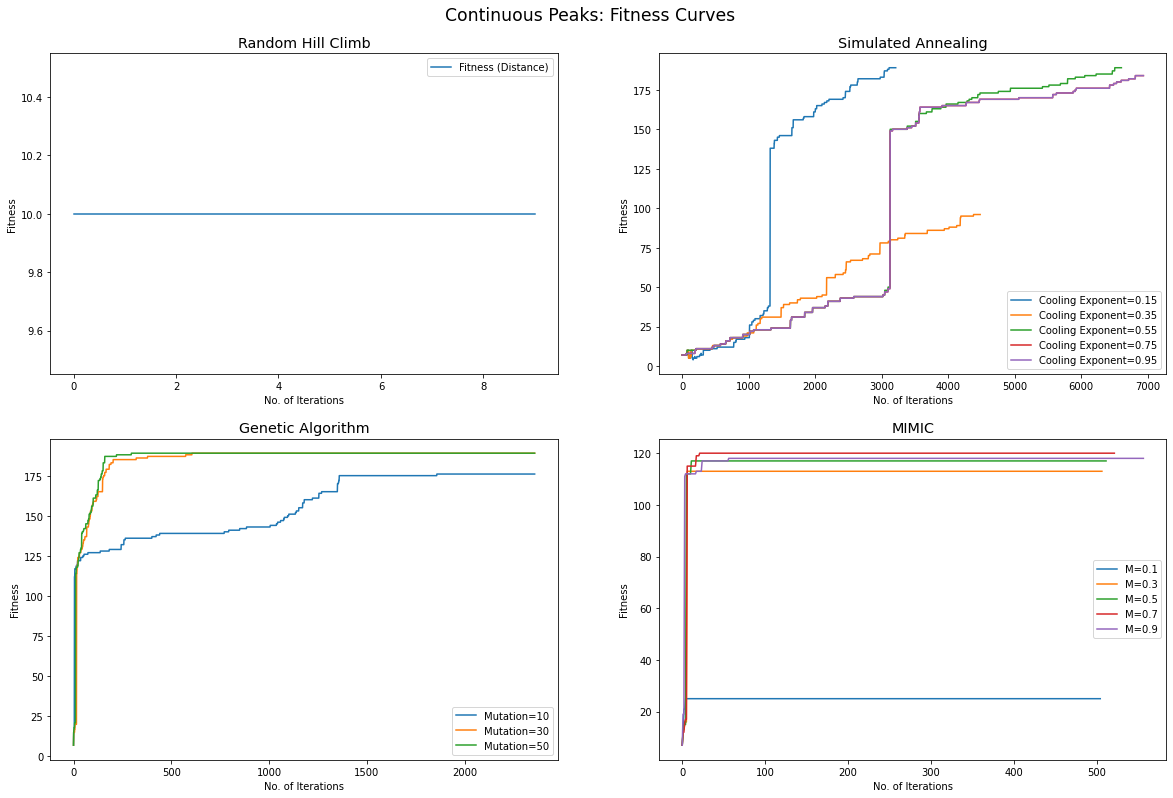

In [4]:
cp = ContinuousPeaksGenerator().generate(seed=21, size=100)
out = run_random_op(cp, 'Continuous Peaks')

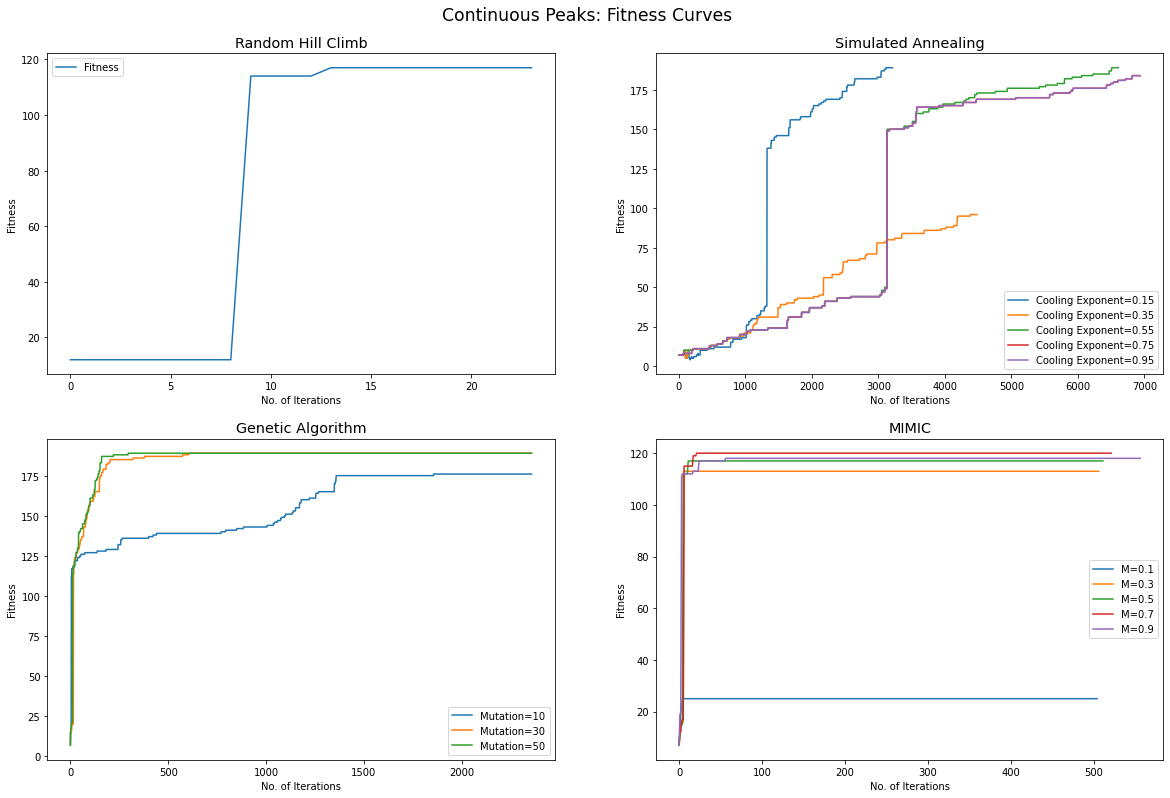

In [25]:
curves_ga = cp_ga.pivot(index='Iteration', columns='Mutation Rate', values='Fitness').fillna(method='ffill')
curves_mm = cp_mimic.pivot(index='Iteration', columns='Keep Percent', values='Fitness')

fig, axes = plt.subplots(2, 2, figsize=(20, 13))

# Random Hill Climb
axes[0][0].plot(cp_rhc[0], label='Fitness')
axes[0][0].set_xlabel('No. of Iterations')
axes[0][0].set_ylabel('Fitness')
axes[0][0].set_title('Random Hill Climb', fontsize='x-large')
axes[0][0].legend(title_fontsize='medium')

# Simulated Annealing
for c in [0.15, 0.35, 0.55, 0.75, 0.95]:
    test = pd.DataFrame(cp_sa[c])
    axes[0][1].plot(test[1], test[0], label=f'Cooling Exponent={c}')
axes[0][1].set_xlabel('No. of Iterations')
axes[0][1].set_ylabel('Fitness')
axes[0][1].set_title('Simulated Annealing', fontsize='x-large')
axes[0][1].legend(title_fontsize='medium')

# Genetic
axes[1][0].plot(curves_ga[0.1], label='Mutation=10')
axes[1][0].plot(curves_ga[0.3], label='Mutation=30')
axes[1][0].plot(curves_ga[0.5], label='Mutation=50')
axes[1][0].set_title('Genetic Algorithm', fontsize='x-large')
axes[1][0].set_xlabel('No. of Iterations')
axes[1][0].set_ylabel('Fitness')
axes[1][0].legend(title_fontsize='medium')

for k in [0.1, 0.3, 0.5, 0.7, 0.9]:
    axes[1][1].plot(curves_mm[k], label=f'M={k}')
    axes[1][1].set_xlabel('No. of Iterations')
    axes[1][1].set_ylabel('Fitness')
    axes[1][1].set_title('MIMIC', fontsize='x-large')
    axes[1][1].legend(title_fontsize='medium')

fig.suptitle('Continuous Peaks: Fitness Curves', fontsize='xx-large', y=0.93);

In [41]:
cp_ga.groupby('Mutation Rate').max()

,Iteration,Time,Fitness,FEvals,Population Size,max_iters
Mutation Rate,,,,,,
0.1,2358,12.751359,176.0,238303.0,100,5000
0.3,1106,9.134430,189.0,111849.0,100,5000
0.5,796,9.134430,189.0,80533.0,100,5000


In [35]:
cp_mimic.groupby('Keep Percent').max()

,Iteration,Time,Fitness,FEvals,use_fast_mimic,Population Size,max_iters
Keep Percent,,,,,,,
0.1,504,1971.242524,25.0,51007.0,False,100,5000
0.3,506,1971.242524,113.0,51210.0,False,100,5000
0.5,511,1971.242524,117.0,51715.0,False,100,5000
0.7,521,1971.242524,120.0,52727.0,False,100,5000
0.9,556,1971.242524,118.0,56262.0,False,100,5000


## Flip Flop

rhc done
sa done:  0.15
sa done:  0.35
sa done:  0.55
sa done:  0.75
sa done:  0.95
ga done
mimic done


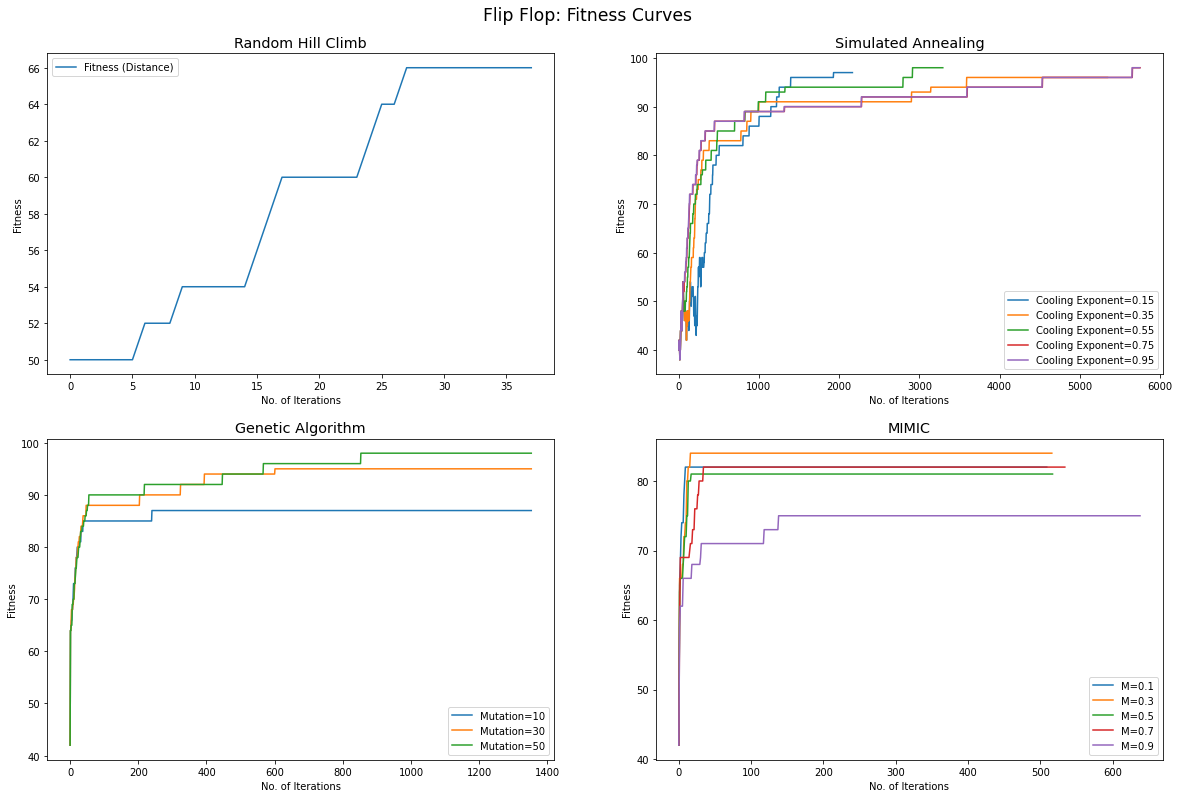

In [5]:
ff = FlipFlopGenerator().generate(seed=21, size=100)
out2 = run_random_op(ff, 'Flip Flop')

In [51]:
ff_rhc, ff_sa, ff_ga, ff_mm = out2

In [65]:
ff_ga.groupby('Mutation Rate').max()

,Iteration,Time,Fitness,FEvals,Population Size,max_iters
Mutation Rate,,,,,,
0.1,740,3.909365,87.0,755.0,100,5000
0.3,1101,6.063995,95.0,1123.0,100,5000
0.5,1353,7.617778,98.0,1378.0,100,5000


In [53]:
ff_mm.groupby('Keep Percent').max()

,Iteration,Time,Fitness,FEvals,use_fast_mimic,Population Size,max_iters
Keep Percent,,,,,,,
0.1,509,1753.629165,82.0,516.0,False,100,5000
0.3,516,1753.629165,84.0,523.0,False,100,5000
0.5,517,1753.629165,81.0,525.0,False,100,5000
0.7,534,1753.629165,82.0,543.0,False,100,5000
0.9,638,1753.629165,75.0,646.0,False,100,5000


# Part 2: Neural Network Optimization

Results obtained through running Jython ABAGAIL via command line.

### Hyperparams of SA, GA

In [26]:
nn_sa = {0.15: pd.read_csv('NN_OUTPUT/NN_SA_0.15_LOG.csv').applymap(float), 
        0.35: pd.read_csv('NN_OUTPUT/NN_SA_0.35_LOG.csv').applymap(float), 
        0.55: pd.read_csv('NN_OUTPUT/NN_SA_0.55_LOG.csv').applymap(float), 
        0.75: pd.read_csv('NN_OUTPUT/NN_SA_0.75_LOG.csv').applymap(float), 
        0.95: pd.read_csv('NN_OUTPUT/NN_SA_0.95_LOG.csv').applymap(float), }

nn_ga = {50: pd.read_csv('NN_OUTPUT/NN_GA_100_30_50_LOG.csv').applymap(float), 
         30: pd.read_csv('NN_OUTPUT/NN_GA_100_30_30_LOG.csv').applymap(float), 
         10: pd.read_csv('NN_OUTPUT/NN_GA_100_30_10_LOG.csv').applymap(float), }

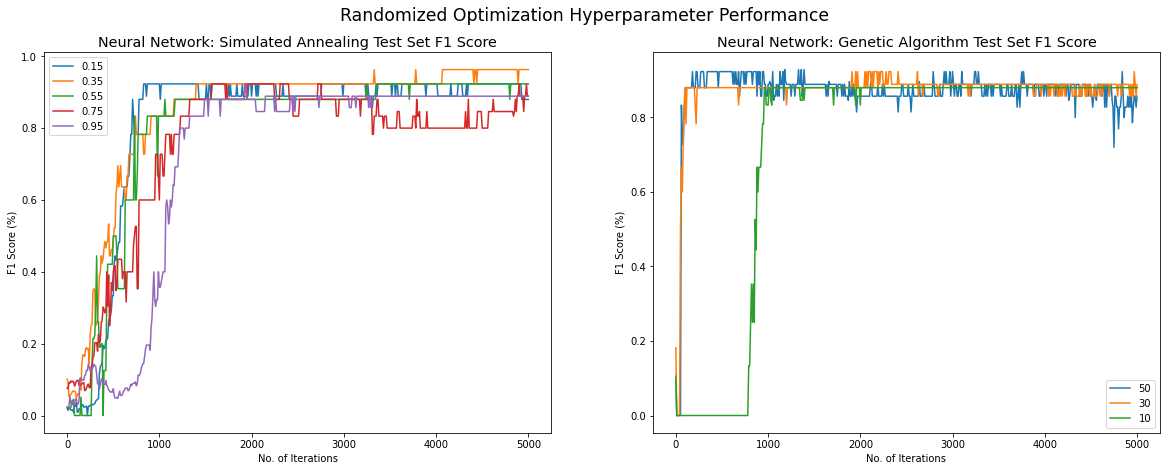

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
for ce in nn_sa:
    axes[0].plot(nn_sa[ce]['iteration'], nn_sa[ce]['f1_tst'], label=ce)
axes[0].set_title('Neural Network: Simulated Annealing Test Set F1 Score', fontsize='x-large')
axes[0].set_xlabel('No. of Iterations')
axes[0].set_ylabel('F1 Score (%)')
axes[0].legend()

for m in nn_ga:
    axes[1].plot(nn_ga[m]['iteration'], nn_ga[m]['f1_tst'], label=m)
axes[1].set_title('Neural Network: Genetic Algorithm Test Set F1 Score', fontsize='x-large')
axes[1].set_xlabel('No. of Iterations')
axes[1].set_ylabel('F1 Score (%)')
axes[1].legend()

fig.suptitle('Randomized Optimization Hyperparameter Performance', fontsize='xx-large', y=0.97);



### Looking at Time/Iterations to Convergence

In [29]:
for ce in nn_sa:
    maxi = nn_sa[ce]['f1_tst'].max()
    df = nn_sa[ce]
    print(ce)
    display(df[df.f1_tst==maxi])

0.15


,iteration,MSE_trg,MSE_val,MSE_tst,acc_trg,acc_val,acc_tst,f1_trg,f1_val,f1_tst,elapsed
83,830.0,0.004831,0.004834,0.005792,0.991614,0.987448,0.993311,0.911111,0.869565,0.923077,1.665384
84,840.0,0.004735,0.004946,0.005633,0.991614,0.987448,0.993311,0.911111,0.869565,0.923077,1.684620
85,850.0,0.004667,0.005172,0.005296,0.991614,0.987448,0.993311,0.911111,0.869565,0.923077,1.708497
87,870.0,0.004350,0.005117,0.004902,0.992662,0.987448,0.993311,0.921348,0.869565,0.923077,1.748656
88,880.0,0.004054,0.004840,0.004848,0.992662,0.987448,0.993311,0.921348,0.869565,0.923077,1.768048
...,...,...,...,...,...,...,...,...,...,...,...
488,4880.0,0.000528,0.002104,0.003349,0.998952,0.995816,0.993311,0.989011,0.956522,0.923077,10.637346
489,4890.0,0.000524,0.002092,0.003361,0.998952,0.995816,0.993311,0.989011,0.956522,0.923077,10.659427
490,4900.0,0.000524,0.002092,0.003351,0.998952,0.995816,0.993311,0.989011,0.956522,0.923077,10.683574
491,4910.0,0.000524,0.002092,0.003371,0.998952,0.995816,0.993311,0.989011,0.956522,0.923077,10.704374


0.35


,iteration,MSE_trg,MSE_val,MSE_tst,acc_trg,acc_val,acc_tst,f1_trg,f1_val,f1_tst,elapsed
333,3330.0,0.001060,0.002708,0.002196,0.997904,0.991632,0.996656,0.977778,0.909091,0.962963,7.642957
378,3780.0,0.001049,0.002191,0.001784,0.997904,0.995816,0.996656,0.977778,0.956522,0.962963,8.764829
407,4070.0,0.001048,0.002136,0.001789,0.997904,0.995816,0.996656,0.977778,0.956522,0.962963,9.426506
408,4080.0,0.001048,0.002131,0.001823,0.997904,0.995816,0.996656,0.977778,0.956522,0.962963,9.447119
409,4090.0,0.001048,0.002124,0.001849,0.997904,0.995816,0.996656,0.977778,0.956522,0.962963,9.468421
...,...,...,...,...,...,...,...,...,...,...,...
496,4960.0,0.001048,0.002241,0.001818,0.997904,0.995816,0.996656,0.977778,0.956522,0.962963,11.472875
497,4970.0,0.001048,0.002241,0.001810,0.997904,0.995816,0.996656,0.977778,0.956522,0.962963,11.492860
498,4980.0,0.001048,0.002241,0.001810,0.997904,0.995816,0.996656,0.977778,0.956522,0.962963,11.513452
499,4990.0,0.001048,0.002241,0.001791,0.997904,0.995816,0.996656,0.977778,0.956522,0.962963,11.536785


0.55


,iteration,MSE_trg,MSE_val,MSE_tst,acc_trg,acc_val,acc_tst,f1_trg,f1_val,f1_tst,elapsed
325,3250.0,0.001084,0.004188,0.003551,0.997904,0.991632,0.993311,0.977778,0.909091,0.923077,6.981972
336,3360.0,0.001052,0.003938,0.003647,0.997904,0.991632,0.993311,0.977778,0.909091,0.923077,7.213811
337,3370.0,0.001052,0.003938,0.003652,0.997904,0.991632,0.993311,0.977778,0.909091,0.923077,7.235476
338,3380.0,0.001051,0.003965,0.003624,0.997904,0.991632,0.993311,0.977778,0.909091,0.923077,7.255009
339,3390.0,0.001050,0.003927,0.003634,0.997904,0.991632,0.993311,0.977778,0.909091,0.923077,7.279522
...,...,...,...,...,...,...,...,...,...,...,...
496,4960.0,0.000524,0.004184,0.003343,0.998952,0.991632,0.993311,0.989011,0.909091,0.923077,10.910904
497,4970.0,0.000524,0.004184,0.003344,0.998952,0.991632,0.993311,0.989011,0.909091,0.923077,10.931194
498,4980.0,0.000524,0.004184,0.003344,0.998952,0.991632,0.993311,0.989011,0.909091,0.923077,10.951639
499,4990.0,0.000524,0.004184,0.003345,0.998952,0.991632,0.993311,0.989011,0.909091,0.923077,10.982791


0.75


,iteration,MSE_trg,MSE_val,MSE_tst,acc_trg,acc_val,acc_tst,f1_trg,f1_val,f1_tst,elapsed
157,1570.0,0.002740,0.004239,0.003952,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,3.560430
158,1580.0,0.002697,0.004192,0.003793,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,3.580891
159,1590.0,0.002676,0.004185,0.003783,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,3.613950
160,1600.0,0.002654,0.004180,0.003855,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,3.635576
161,1610.0,0.002647,0.004181,0.003859,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,3.655730
...,...,...,...,...,...,...,...,...,...,...,...
273,2730.0,0.000735,0.003878,0.003532,0.998952,0.991632,0.993311,0.989011,0.909091,0.923077,6.112848
274,2740.0,0.000735,0.003883,0.003531,0.998952,0.991632,0.993311,0.989011,0.909091,0.923077,6.136942
275,2750.0,0.000739,0.003971,0.003264,0.998952,0.991632,0.993311,0.989011,0.909091,0.923077,6.156919
490,4900.0,0.000524,0.004182,0.003731,0.998952,0.991632,0.993311,0.989011,0.909091,0.923077,11.056624


0.95


,iteration,MSE_trg,MSE_val,MSE_tst,acc_trg,acc_val,acc_tst,f1_trg,f1_val,f1_tst,elapsed
193,1930.0,0.002574,0.004634,0.004264,0.994759,0.991632,0.993311,0.942529,0.909091,0.923077,4.668614
194,1940.0,0.002571,0.004633,0.004298,0.994759,0.991632,0.993311,0.942529,0.909091,0.923077,4.692772


In [30]:
for ce in nn_ga:
    maxi = nn_ga[ce]['f1_tst'].max()
    df = nn_ga[ce]
    print(ce)
    print('max:', df.iloc[-1])
    display(df[df.f1_tst==maxi])

50
max: iteration    5000.000000
MSE_trg         0.001615
MSE_val         0.003953
MSE_tst         0.004449
acc_trg         0.996855
acc_val         0.991632
acc_tst         0.986622
f1_trg          0.966292
f1_val          0.916667
f1_tst          0.857143
elapsed       464.940027
Name: 500, dtype: float64


,iteration,MSE_trg,MSE_val,MSE_tst,acc_trg,acc_val,acc_tst,f1_trg,f1_val,f1_tst,elapsed
118,1180.0,0.001784,0.002147,0.003093,0.996855,0.995816,0.993311,0.966292,0.956522,0.928571,105.121171
133,1330.0,0.001840,0.002138,0.003197,0.996855,0.995816,0.993311,0.966292,0.956522,0.928571,118.786381
136,1360.0,0.001772,0.002121,0.003589,0.996855,0.995816,0.993311,0.966292,0.956522,0.928571,121.432547
139,1390.0,0.001844,0.002117,0.003582,0.996855,0.995816,0.993311,0.966292,0.956522,0.928571,124.120545


30
max: iteration    5000.000000
MSE_trg         0.001588
MSE_val         0.002316
MSE_tst         0.004047
acc_trg         0.996855
acc_val         0.995816
acc_tst         0.989967
f1_trg          0.966292
f1_val          0.956522
f1_tst          0.888889
elapsed       383.848676
Name: 500, dtype: float64


,iteration,MSE_trg,MSE_val,MSE_tst,acc_trg,acc_val,acc_tst,f1_trg,f1_val,f1_tst,elapsed
191,1910.0,0.002948,0.003897,0.003946,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,144.436110
195,1950.0,0.002913,0.003874,0.003800,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,147.541226
197,1970.0,0.002907,0.003940,0.003874,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,149.082652
205,2050.0,0.002899,0.004118,0.003631,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,155.244379
207,2070.0,0.002672,0.003719,0.003746,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,156.785718
209,2090.0,0.002922,0.003989,0.003778,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,158.360263
210,2100.0,0.002929,0.004093,0.003693,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,159.140458
211,2110.0,0.002829,0.004126,0.003871,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,159.910961
213,2130.0,0.002777,0.003809,0.004103,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,161.453579
215,2150.0,0.002854,0.003866,0.003907,0.993711,0.991632,0.993311,0.930233,0.909091,0.923077,163.007155


10
max: iteration    5000.000000
MSE_trg         0.002818
MSE_val         0.004235
MSE_tst         0.004856
acc_trg         0.993711
acc_val         0.991632
acc_tst         0.989967
f1_trg          0.930233
f1_val          0.909091
f1_tst          0.880000
elapsed       295.020782
Name: 500, dtype: float64


,iteration,MSE_trg,MSE_val,MSE_tst,acc_trg,acc_val,acc_tst,f1_trg,f1_val,f1_tst,elapsed
96,960.0,0.005321,0.005500,0.006775,0.990566,0.991632,0.989967,0.894118,0.909091,0.88,56.484361
97,970.0,0.005259,0.005934,0.007044,0.990566,0.987448,0.989967,0.894118,0.869565,0.88,57.080263
101,1010.0,0.005207,0.005766,0.006866,0.992662,0.991632,0.989967,0.917647,0.909091,0.88,59.464465
102,1020.0,0.005015,0.005517,0.006549,0.992662,0.991632,0.989967,0.917647,0.909091,0.88,60.071969
105,1050.0,0.004977,0.005231,0.006466,0.991614,0.991632,0.989967,0.904762,0.909091,0.88,61.869953
...,...,...,...,...,...,...,...,...,...,...,...
496,4960.0,0.002867,0.004168,0.004883,0.993711,0.991632,0.989967,0.930233,0.909091,0.88,292.739842
497,4970.0,0.002822,0.004221,0.004763,0.993711,0.991632,0.989967,0.930233,0.909091,0.88,293.330607
498,4980.0,0.002815,0.004212,0.004719,0.993711,0.991632,0.989967,0.930233,0.909091,0.88,293.886486
499,4990.0,0.002797,0.004229,0.004800,0.993711,0.991632,0.989967,0.930233,0.909091,0.88,294.455229


In [31]:
backprop = pd.read_csv('NN_OUTPUT/NN_Backprop_LOG.csv')
backprop = backprop.drop([0, 1])
backprop = backprop.applymap(float).iloc[:40]

randomhc = pd.read_csv('NN_OUTPUT/NN_RHC_LOG.csv').applymap(float)

simann = pd.read_csv('NN_OUTPUT/NN_SA_0.35_LOG.csv').applymap(float)

genalg = pd.read_csv('NN_OUTPUT/NN_GA_100_30_10_LOG.csv').applymap(float)

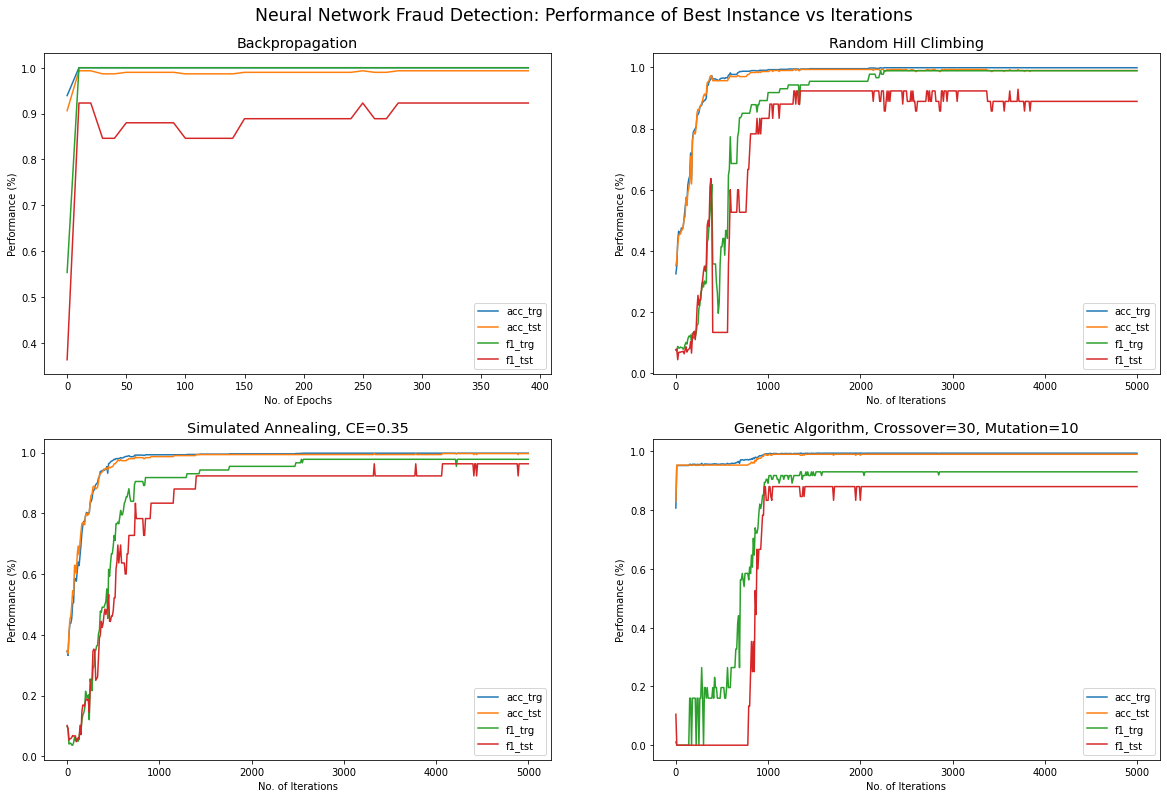

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(20, 13))

# Backprop
for col in ['acc_trg', 'acc_tst', 'f1_trg', 'f1_tst']:
    axes[0][0].plot(backprop.iteration, backprop[col], label=col)
    
axes[0][0].set_xlabel('No. of Epochs')
axes[0][0].set_ylabel('Performance (%)')
axes[0][0].set_title('Backpropagation', fontsize='x-large')
axes[0][0].legend(title_fontsize='medium')

# RHC
for col in ['acc_trg', 'acc_tst', 'f1_trg', 'f1_tst']:
    axes[0][1].plot(randomhc.iteration, randomhc[col], label=col)
axes[0][1].set_xlabel('No. of Iterations')
axes[0][1].set_ylabel('Performance (%)')
axes[0][1].set_title('Random Hill Climbing', fontsize='x-large')
axes[0][1].legend(title_fontsize='medium')

# SA
for col in ['acc_trg', 'acc_tst', 'f1_trg', 'f1_tst']:
    axes[1][0].plot(simann.iteration, simann[col], label=col)
axes[1][0].set_xlabel('No. of Iterations')
axes[1][0].set_ylabel('Performance (%)')
axes[1][0].set_title('Simulated Annealing, CE=0.35', fontsize='x-large')
axes[1][0].legend(title_fontsize='medium')

# GA
for col in ['acc_trg', 'acc_tst', 'f1_trg', 'f1_tst']:
    axes[1][1].plot(genalg.iteration, genalg[col], label=col)
axes[1][1].set_xlabel('No. of Iterations')
axes[1][1].set_ylabel('Performance (%)')
axes[1][1].set_title('Genetic Algorithm, Crossover=30, Mutation=10', fontsize='x-large')
axes[1][1].legend(title_fontsize='medium')

fig.suptitle('Neural Network Fraud Detection: Performance of Best Instance vs Iterations', fontsize='xx-large', y=0.93);